In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

student_colors = {'Chris': 'Grey', 'Erin': 'Red', 'Jeshu': 'Orange', 
                  'Jimmy': 'Gold', 'Jisu': 'Green', 'Joshua': 'Cyan', 
                  'Mehul': 'Blue', 'Nolan': 'Purple', 'Satyam': 'Magenta'}

name = 'Chris'

In [2]:
def calibrate_energy(channels, m, b):
    return m*channels+b

def import_spectra(data_file):
    """
    data_file in the format of a GammaVision .spe file
    """
    with open(data_file, 'r') as f:
        data = f.readlines()
        
    start_data = data.index('$DATA:\n')+2
    counts = np.array([float(val.strip()) for val in data[start_data:start_data+8192]])

    b_cal, m_cal = list(map(float, data[data.index('$ENER_FIT:\n')+1].strip().split(' ')))

    l_time, r_time = list(map(float, data[data.index('$MEAS_TIM:\n')+1].strip().split(' ')))
    
    calibrated_e = calibrate_energy(np.arange(len(counts)), m_cal, b_cal) # in units of keV
    
    spectra_dict = {'Counts': counts,
                    'Count Rate': counts/l_time,
                    'Energy': calibrated_e, 
                    'Live Time': l_time,
                    'Real Time': r_time,
                    'm': m_cal, 'b': b_cal}
    return spectra_dict

def plot_spectra(spectra_dict, source=None, mode='rate', name=name):
    # Mode can be either 'rate' or 'counts'
    col = student_colors[name]
    
    fig = plt.figure(dpi=300, figsize=[14,8], facecolor='white')
    ax = plt.gca()
    
    if mode == 'rate':
        plt.plot(spectra_dict['Energy'], spectra_dict['Count Rate'], color=col)
        plt.fill_between(spectra_dict['Energy'], spectra_dict['Count Rate'], alpha=1, color=col)
        plt.ylabel('Count Rate [cps]', fontsize=15)
    elif mode == 'counts':
        plt.plot(spectra_dict['Energy'], spectra_dict['Counts'], color=col)
        plt.fill_between(spectra_dict['Energy'], spectra_dict['Counts'], alpha=1, color=col)
        plt.ylabel('Counts', fontsize=15)
    plt.xlabel('Energy [kev]', fontsize=15)
        
    if source is not None:
        plt.title('{} Gamma Spectrum'.format(source), fontsize=15, fontweight='bold')
    
    plt.semilogy()
    ax.set_axisbelow(True)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    plt.grid(which='major')
    plt.grid(axis='y', which='minor', linestyle='--', alpha=0.2)
    
    return fig, ax

In [3]:
f_dir = 'Data/'
f_name = 'Data/Cs137-HPGe.Spe'.strip(f_dir) # Using the directory so I can tab-complete (lazy)
spectra_dict = import_spectra(f_dir+f_name)

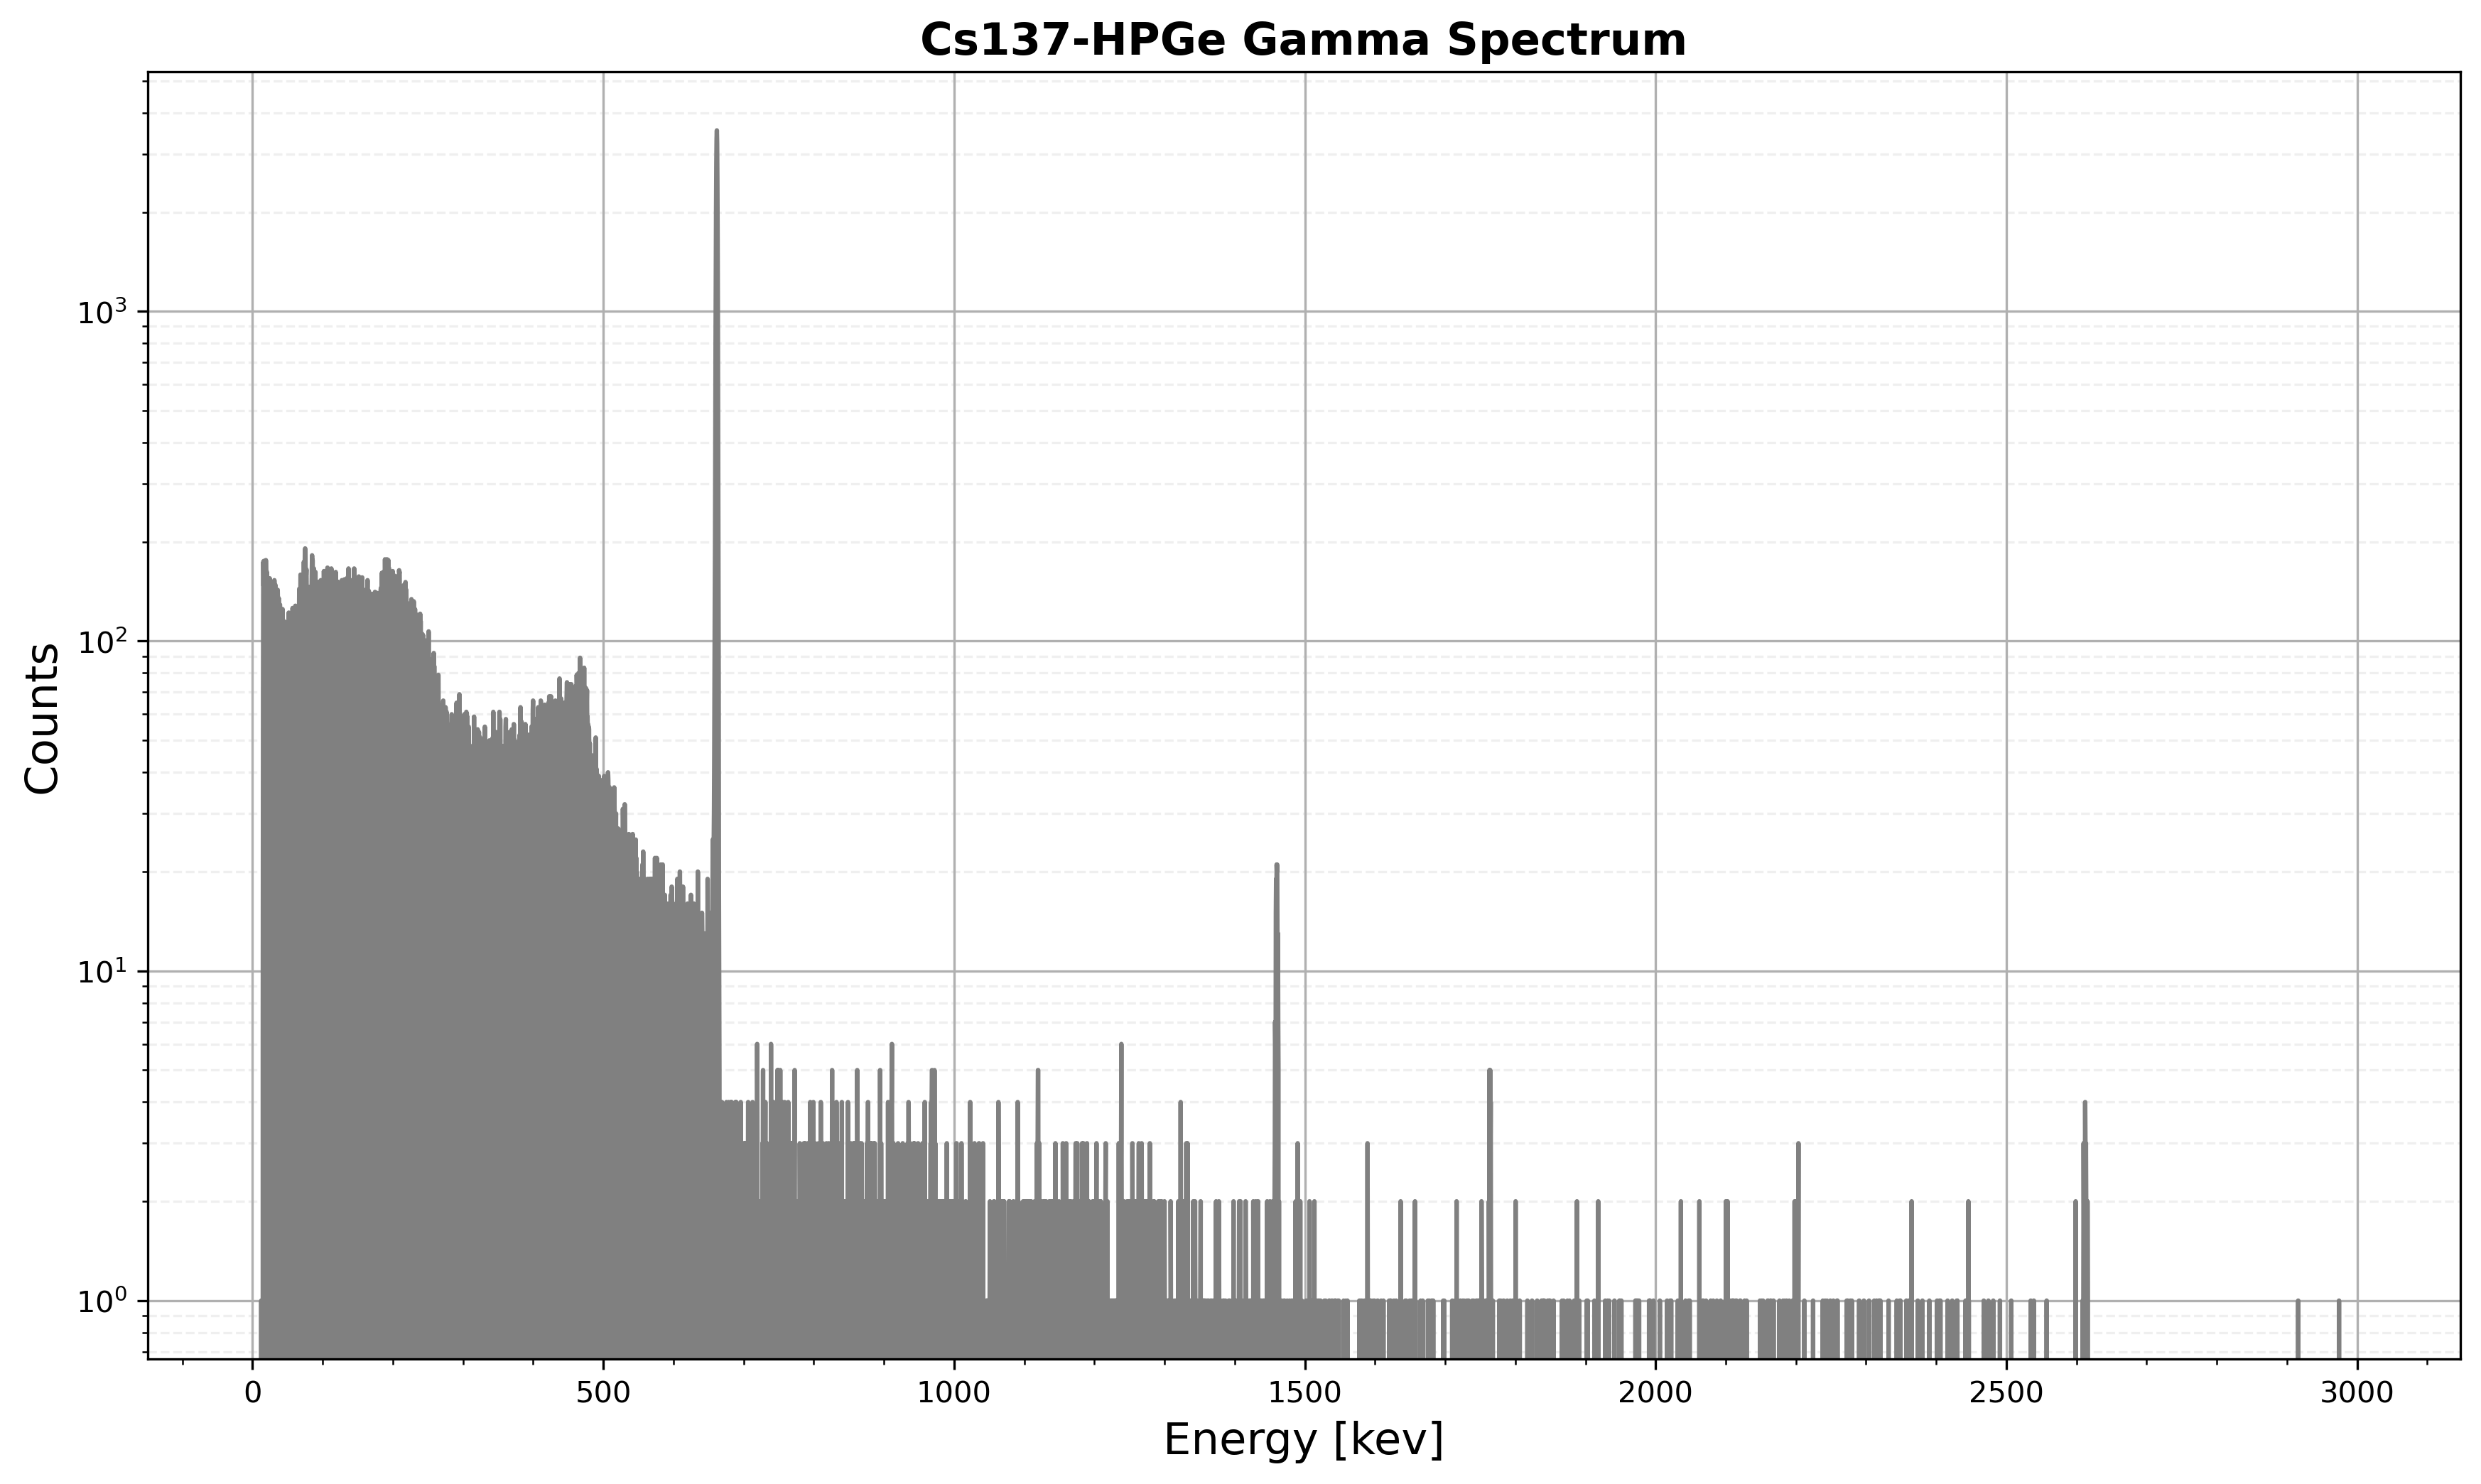

In [4]:
plot_spectra(spectra_dict, f_name.strip('Spe')[:-1], mode='counts')
plt.savefig('Plots/{}.png'.format(f_name.strip('Spe')[:-1]), bbox_inches='tight')

In [5]:
def background_subtract(spectra_dict, background_file='Data/Background-HPGe.Spe'):
    """
    Imports background spectra and subtracts it from the input spectra
    Assumes that the input spectra and the background spectra have the same energy calibration
    Returns a background subtracted spectra in units of cps
    """
    b_spec_dict = import_spectra(background_file)
    
    return spectra_dict['Count Rate'] - b_spec_dict['Count Rate']

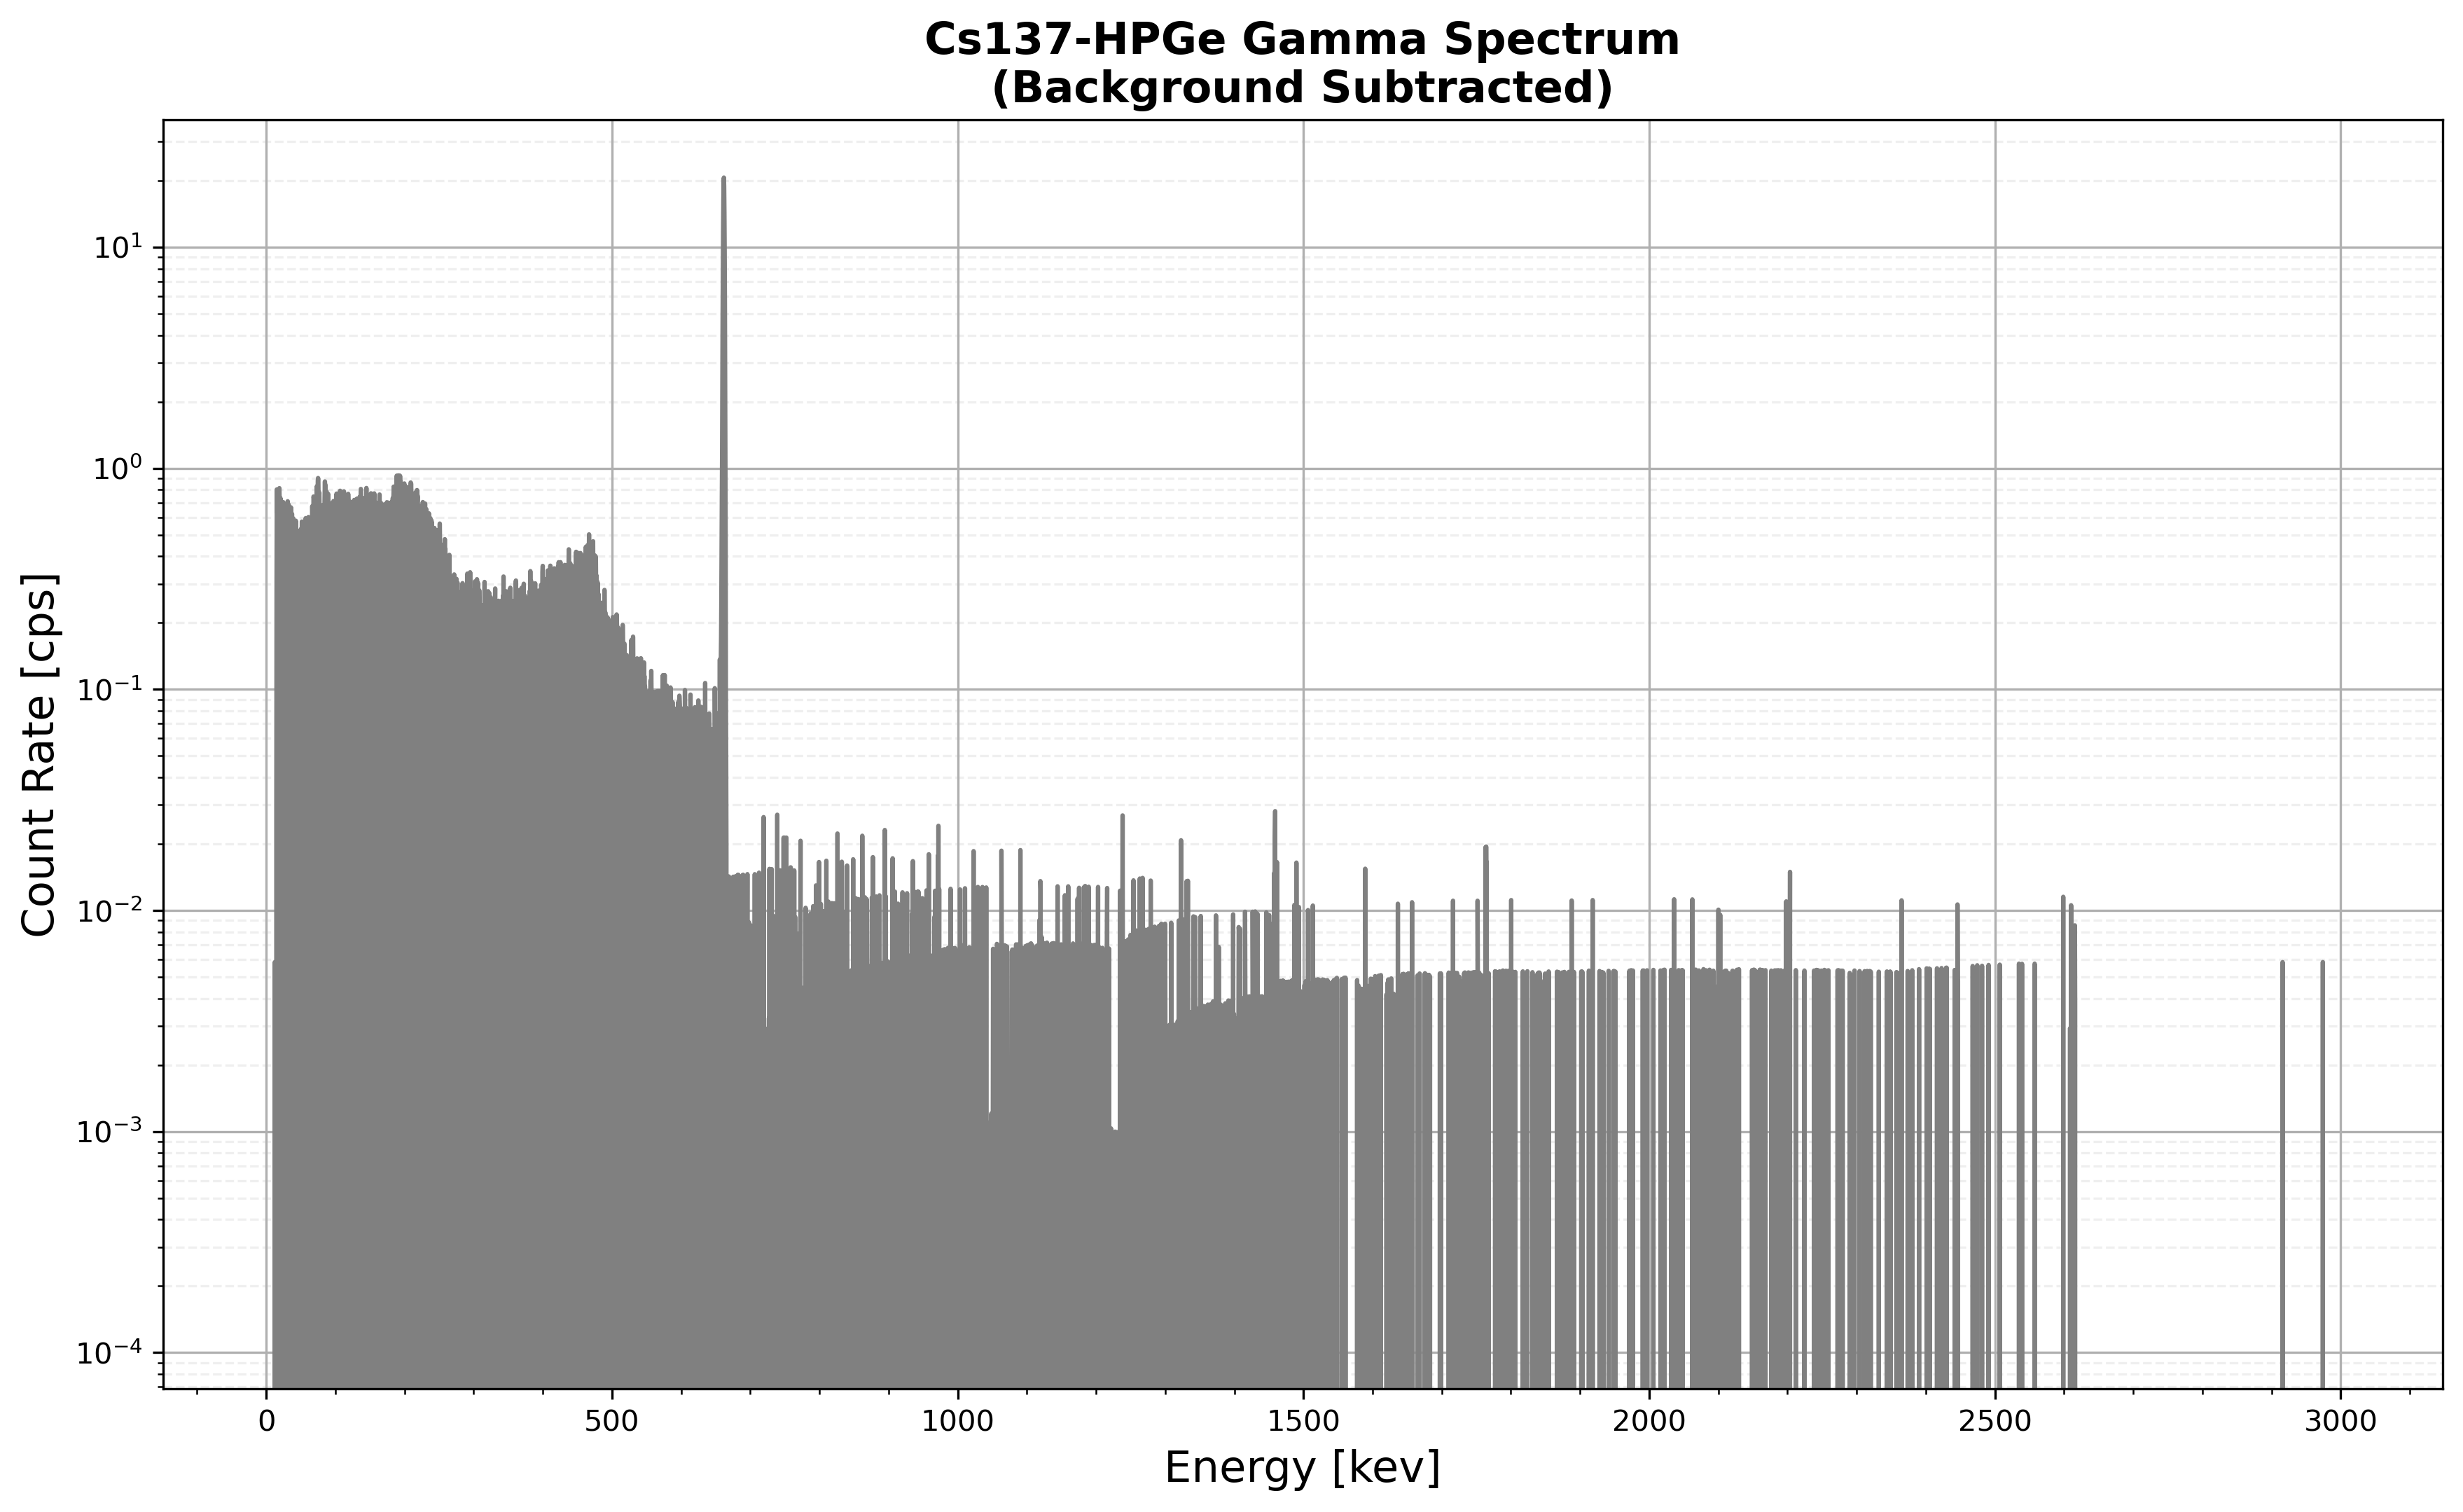

In [6]:
col = student_colors[name]
plt.figure(dpi=300, figsize=[14,8], facecolor='white')
ax = plt.gca()
spectra_dict['BS Count Rate'] = background_subtract(spectra_dict)

plt.plot(spectra_dict['Energy'], spectra_dict['BS Count Rate'], color=col)
plt.fill_between(spectra_dict['Energy'], spectra_dict['BS Count Rate'], alpha=1, color=col)

plt.xlabel('Energy [kev]', fontsize=15)
plt.ylabel('Count Rate [cps]', fontsize=15)
plt.title('{} Gamma Spectrum\n(Background Subtracted)'.format(f_name.strip('Spe')[:-1]), fontsize=15, fontweight='bold')
plt.semilogy()
ax.set_axisbelow(True)
ax.xaxis.set_minor_locator(MultipleLocator(100))
plt.grid(which='major')
plt.grid(axis='y', which='minor', linestyle='--', alpha=0.2)
# plt.savefig('Plots/{}_bs.png'.format(f_name.strip('Spe')[:-1]), bbox_inches='tight')
plt.show()